# Sensory analysis 

> 2-way ANOVA... examines the effect of two different categorical independent variables or two independent factors on one continuous depedent variable.

> Balanced design... all sample sizes for all combinations of groups are equal. 

=> note, this is from the 2021 samples!


### 0. Setup

In [8]:
import pandas as pd
import numpy as np

# Statics 
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from math import pi

# Visualizations 
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import mpl_axes_aligner

%matplotlib inline

In [9]:
# my palette!
palette_GB = sns.diverging_palette(124, 220, as_cmap=True)

# custom Blue colormap that starts darker
colors = [(0.2, 0.4, 0.6), (0.3, 0.5, 0.7), (0.4, 0.6, 0.8), (0.5, 0.7, 0.9), (0.6, 0.8, 1.0)]  # starting with a darker blue
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_blues'
custom_blues = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [10]:
workdir = '/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensory'
%cd $workdir

/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensory


In [11]:
# read in 
data = pd.read_csv('Sensory_analysis_2023_06_01.csv')

# Replace all zeros with 0.001 (some judges put a lot of zeros, to still interpret these values we replace them with a very small one)
data = data.replace(0, 0.001)

In [12]:
# these are my categorical and numerical columns 
categorical_cols = ['Sample', 'Judge']
numeric_cols = [col for col in data.columns if col not in categorical_cols]

### Test and have a look if data is normally distributed 

... nope!

In [13]:
# Perform normality tests for each column
for column in data[numeric_cols]:
    values = data[column]
    
    # Shapiro-Wilk test
    shapiro_test = stats.shapiro(values)
    shapiro_statistic = shapiro_test.statistic
    shapiro_p_value = shapiro_test.pvalue
    
    # Anderson-Darling test
    anderson_test = stats.anderson(values)
    anderson_statistic = anderson_test.statistic
    anderson_critical_values = anderson_test.critical_values
    anderson_significance_level = anderson_test.significance_level
    
    print(f'Column: {column}')
    print('Shapiro-Wilk Test:')
    print(f'Statistic: {shapiro_statistic}')
    print(f'p-value: {shapiro_p_value}')
    print('Anderson-Darling Test:')
    print(f'Statistic: {anderson_statistic}')
    print(f'Critical Values: {anderson_critical_values}')
    print(f'Significance Level: {anderson_significance_level}')
    print('\n')


Column: Olfactory_intensity
Shapiro-Wilk Test:
Statistic: 0.9842802535731944
p-value: 0.176897506092342
Anderson-Darling Test:
Statistic: 0.7564745175924656
Critical Values: [0.558 0.636 0.763 0.89  1.059]
Significance Level: [15.  10.   5.   2.5  1. ]


Column: Citrus
Shapiro-Wilk Test:
Statistic: 0.7042383293227648
p-value: 3.1416647933119354e-14
Anderson-Darling Test:
Statistic: 15.74318224879363
Critical Values: [0.558 0.636 0.763 0.89  1.059]
Significance Level: [15.  10.   5.   2.5  1. ]


Column: Exotic_fruit
Shapiro-Wilk Test:
Statistic: 0.7923333880775683
p-value: 9.745607722890737e-12
Anderson-Darling Test:
Statistic: 9.262466502640677
Critical Values: [0.558 0.636 0.763 0.89  1.059]
Significance Level: [15.  10.   5.   2.5  1. ]


Column: White_fruit
Shapiro-Wilk Test:
Statistic: 0.9261830958227252
p-value: 5.604631500792553e-06
Anderson-Darling Test:
Statistic: 2.251959562878767
Critical Values: [0.558 0.636 0.763 0.89  1.059]
Significance Level: [15.  10.   5.   2.5  1. ]


## 2. Two-way ANOVA

In [14]:
# Two way ANOVA for all columns - note since we have no replicates we cannot test the interactions

# save the respective p values in the lists 
p_value_sample = []
p_value_judge = []

# iterate over all columns and calculate the p value for each factor 
for col in data[numeric_cols]:
    formula = f'{col} ~ {categorical_cols[1]} + {categorical_cols[0]}'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value_sample.append("{:.2e}".format(anova_table.at['Sample','PR(>F)']))
    p_value_judge.append("{:.2e}".format(anova_table.at['Judge','PR(>F)']))
    print(f"Results for {col}:\n{anova_table}\n")

Results for Olfactory_intensity:
              sum_sq    df          F        PR(>F)
Judge     242.469929  11.0  13.845124  1.080151e-15
Sample      8.919571   9.0   0.622491  7.753671e-01
Residual  157.617179  99.0        NaN           NaN



Results for Citrus:
             sum_sq    df          F        PR(>F)
Judge     77.339185  11.0  10.267053  2.838284e-12
Sample     8.671212   9.0   1.406942  1.953910e-01
Residual  67.794786  99.0        NaN           NaN

Results for Exotic_fruit:
              sum_sq    df         F        PR(>F)
Judge     225.366127  11.0  6.543091  4.264684e-08
Sample     33.903234   9.0  1.203055  3.017646e-01
Residual  309.990339  99.0       NaN           NaN

Results for White_fruit:
              sum_sq    df         F    PR(>F)
Judge     172.399673  11.0  4.083847  0.000061
Sample     47.115254   9.0  1.364095  0.214736
Residual  379.935173  99.0       NaN       NaN

Results for Floral:
              sum_sq    df         F    PR(>F)
Judge     143.181271  11.0  4.375354  0.000025
Sample     41.826547   9.0  1.562173  0.137197
Residual  294.520505  99.0       NaN       NaN

Results for Green_notes:
              sum_sq    df         F    PR(>F)
Judge      70.305134  11.0  4.068314  0.000064
S

## PCA
... visually check the scatter of samples by the metadata categories. 

In [15]:
# scale the data to the range between 0 and 1 before using PCA
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data[numeric_cols])

In [16]:
# explaine 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

data_pca = data 

# Add PCA results to dataframe
data_pca['PC1'] = reduced[:, 0]
data_pca['PC2'] = reduced[:, 1]

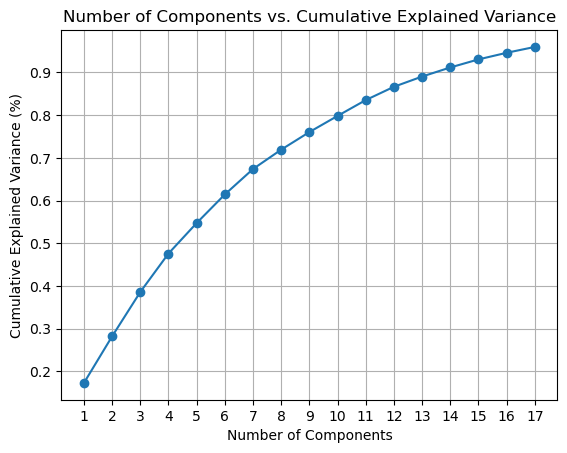

In [17]:
# Get the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Plot the number of components vs. explained variance
plt.plot(range(1, len(explained_variance_ratios) + 1), cumulative_explained_variance, marker='o')
plt.title('Number of Components vs. Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.xticks(range(1, len(explained_variance_ratios) + 1))
plt.grid(True)
plt.show()

In [18]:
# Get the estimated number of components 
pca.n_components_

17

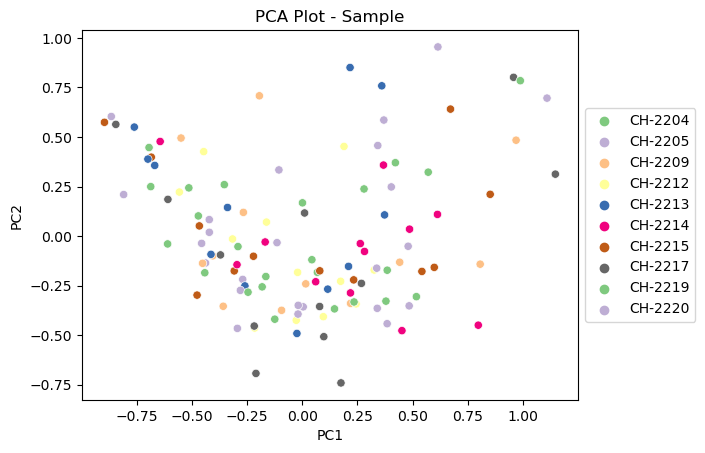

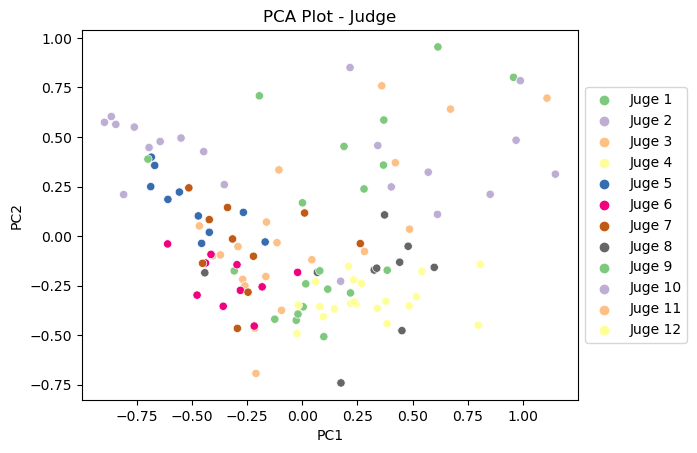

In [19]:
# Plot scatterplot with colors based on Category1
sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue='Sample', palette='Accent')
plt.title('PCA Plot - Sample')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot scatterplot with colors based on Category2
sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue='Judge', palette='Accent')
plt.title('PCA Plot - Judge')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# All data in context of metadata

In [22]:
# Plots Metadata
plots_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/RawMD-Lavaux_plots.csv', index_col=0)

In [23]:
data['Plot'] = data['Sample'].str.extract(r'CH-22(\d+)').astype(int)
data.set_index('Plot', inplace=True)
# data.drop(columns=['Sample', 'PC1', 'PC2'], inplace=True)
data.head()

,Sample,Judge,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,...,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length,PC1,PC2
Plot,,,,,,,,,,,,,,,,,,,,,
4,CH-2204,Juge 1,8.25,1.17,3.14,5.28,2.44,0.15,1.19,0.06,...,4.32,3.54,0.44,5.68,2.56,5.21,1.66,5.35,0.384963,-0.172370
5,CH-2205,Juge 1,5.28,1.62,0.55,3.05,1.26,2.42,1.04,4.74,...,3.96,3.63,0.97,4.97,2.13,4.63,2.49,5.06,0.004525,-0.357280
9,CH-2209,Juge 1,4.16,0.08,0.06,1.73,1.26,2.33,1.95,0.68,...,3.58,4.52,2.31,3.94,3.61,3.36,4.43,3.40,0.016021,-0.241239
12,CH-2212,Juge 1,3.45,0.01,0.03,1.28,1.08,2.20,1.26,3.45,...,4.25,4.86,0.59,4.65,3.09,5.46,2.38,5.23,-0.027012,-0.425082
13,CH-2213,Juge 1,4.79,0.55,0.95,2.22,0.15,1.19,0.81,3.40,...,5.12,4.70,0.81,5.28,3.61,4.32,2.82,4.97,0.115622,-0.267963


In [25]:
# Microvinification data
mv_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Raw-MD_Vineyard_MV_data.csv', index_col=0)
# only 2022 metadata
mv_md_2021= mv_md[mv_md['Year']==2021]

In [26]:
# merge all!
merged_df_all = data.join([mv_md_2021, plots_md])

# these are the sensory cols 
sensory_cols = ['Olfactory_intensity', 'Citrus', 'Exotic_fruit',
       'White_fruit', 'Floral', 'Green_notes', 'Honey', 'Milk', 'Mineral',
       'Reduction', 'Oxidation', 'Olfactory_complexity', 'CO2', 'Acidity',
       'Bitterness', 'Sweetness', 'Volume_in_the_mouth', 'Balance', 'Alcohol',
       'Freshness_on_the_palate', 'Aromatic_length']

### Plot Metadata

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


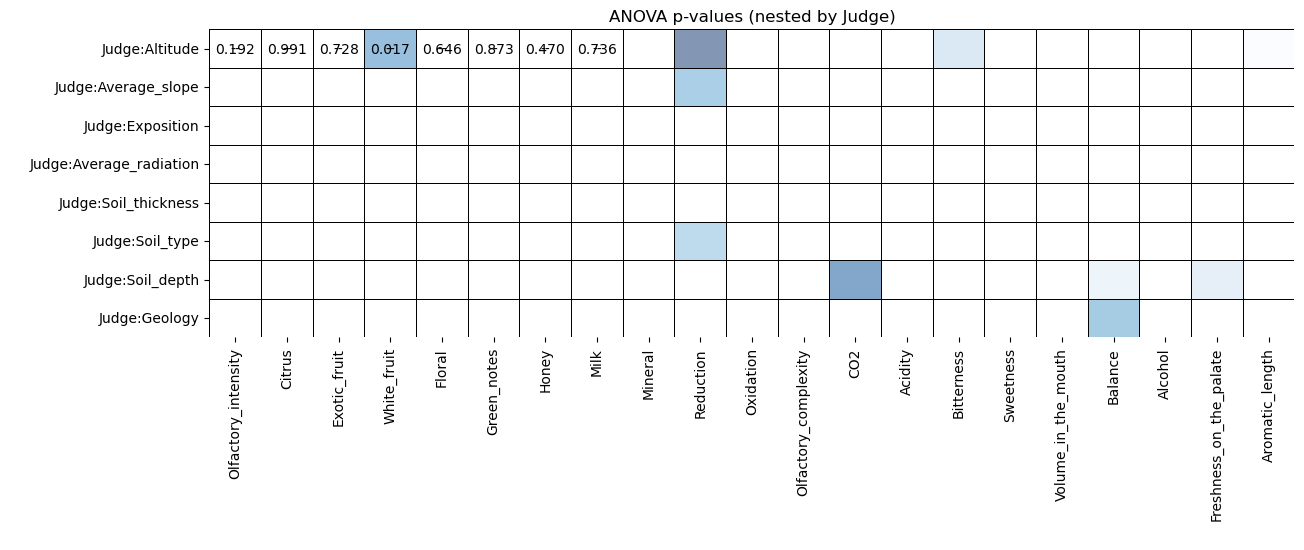

In [27]:
# ANOVA 
interaction_terms = ['Judge:Altitude', 'Judge:Average_slope', 'Judge:Exposition', 'Judge:Average_radiation', 'Judge:Soil_thickness', 'Judge:Soil_type', 'Judge:Soil_depth', 'Judge:Geology']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Judge:Altitude + Judge:Average_slope + Judge:Exposition + Judge:Average_radiation + Judge:Soil_thickness + Judge:Soil_type + Judge:Soil_depth + Judge:Geology"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (nested by Judge)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


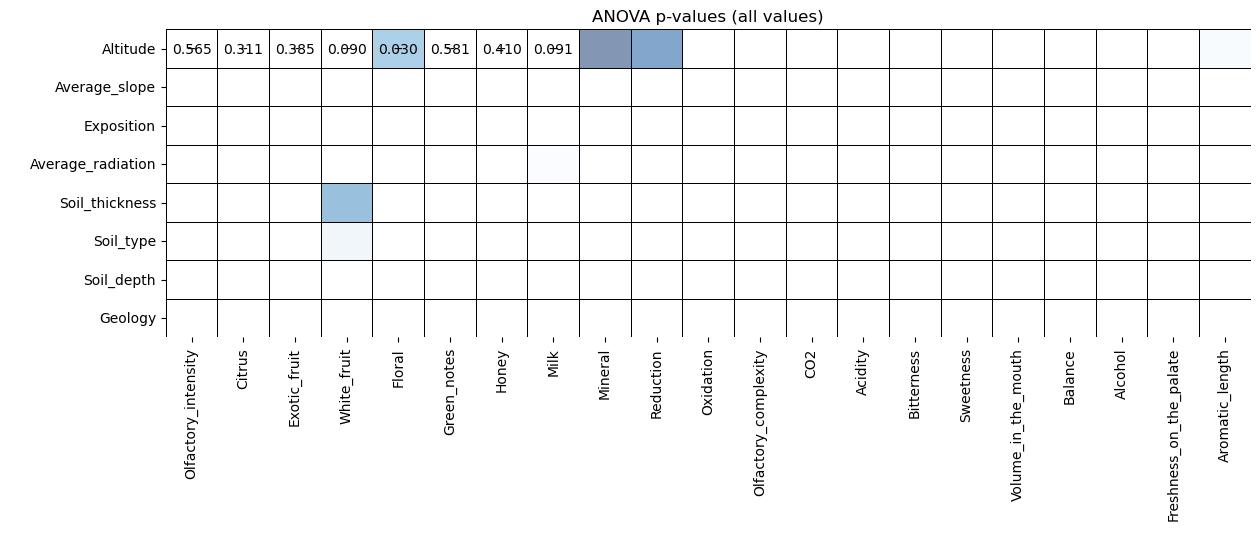

In [28]:
# ANOVA 
interaction_terms = ['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Soil_thickness', 'Soil_type', 'Soil_depth', 'Geology']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Altitude + Average_slope + Exposition + Average_radiation + Soil_thickness + Soil_type + Soil_depth + Geology"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (all values)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

### Phenology

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


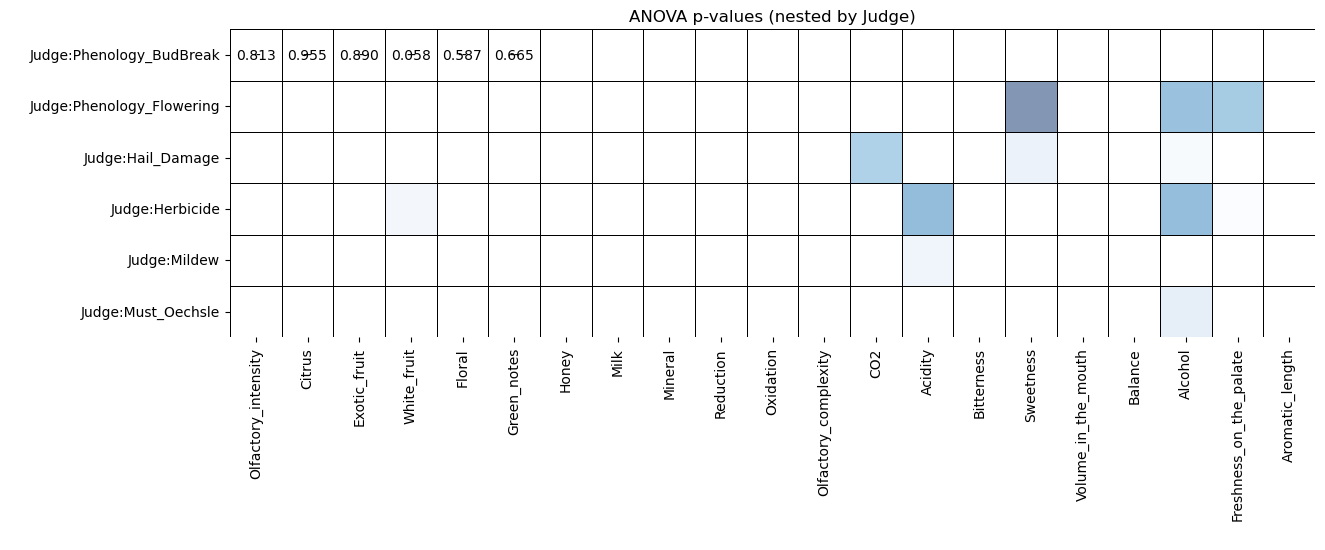

In [29]:
# ANOVA 
interaction_terms = ['Judge:Phenology_BudBreak', 'Judge:Phenology_Flowering', 'Judge:Hail_Damage', 'Judge:Herbicide', 'Judge:Mildew', 'Judge:Must_Oechsle']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Judge:Phenology_Flowering + Judge:Phenology_BudBreak + Judge:Hail_Damage+ Judge:Herbicide + Judge:Mildew + Judge:Must_Oechsle"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (nested by Judge)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


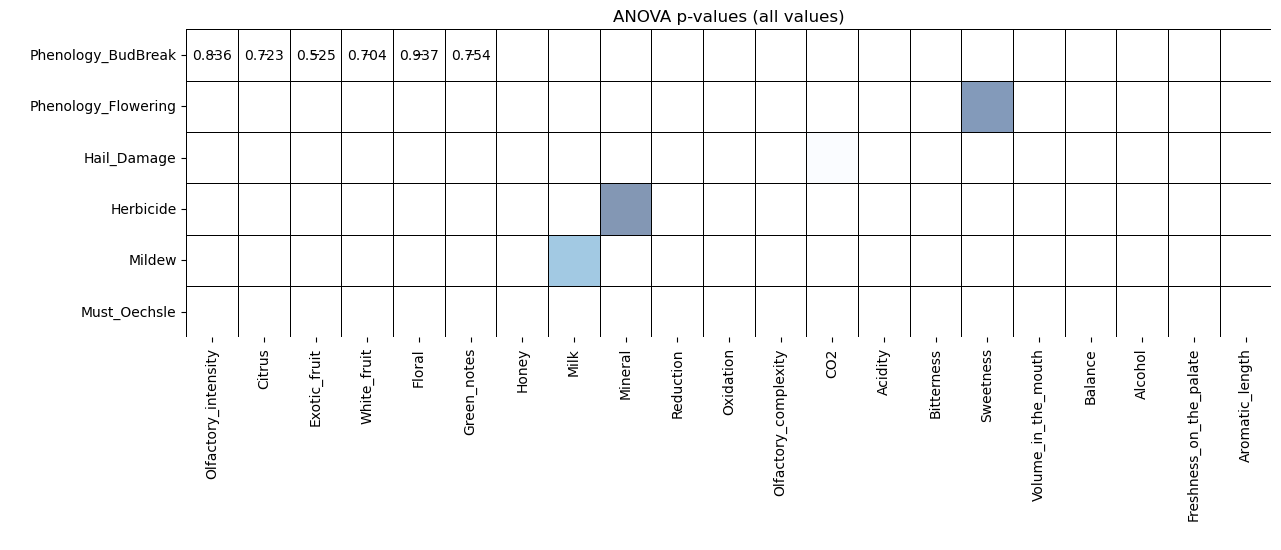

In [30]:
# ANOVA 
interaction_terms = ['Phenology_BudBreak', 'Phenology_Flowering', 'Hail_Damage', 'Herbicide', 'Mildew', 'Must_Oechsle']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Phenology_Flowering + Phenology_BudBreak + Hail_Damage+ Herbicide + Mildew + Must_Oechsle"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (all values)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

### Wine Chemistry

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


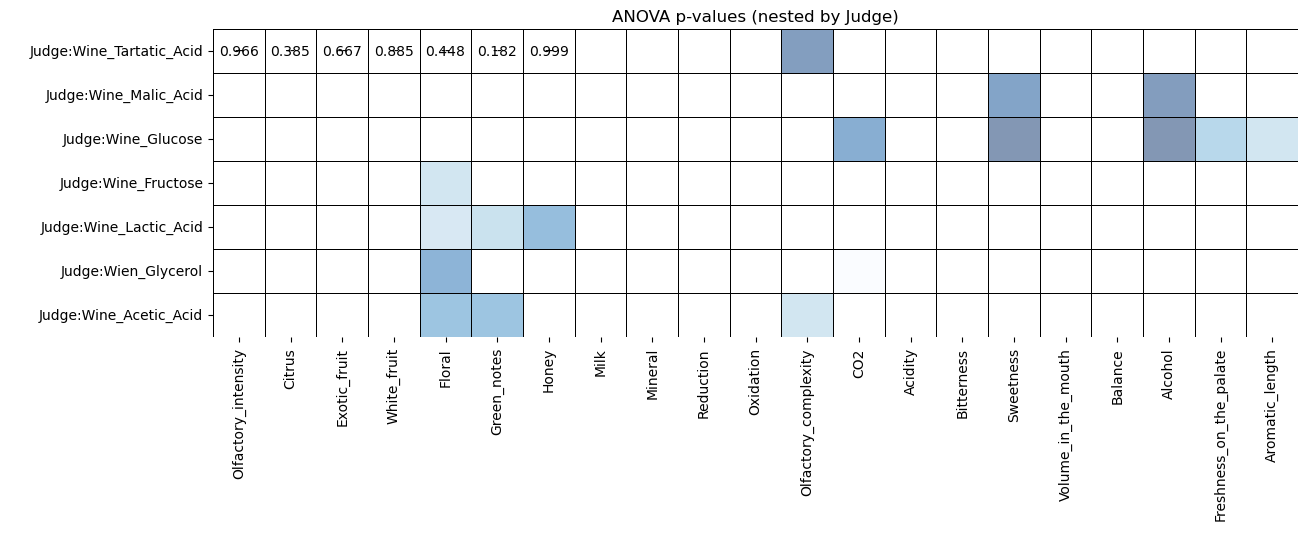

In [31]:
# ANOVA 
interaction_terms = ['Judge:Wine_Tartatic_Acid', 'Judge:Wine_Malic_Acid', 'Judge:Wine_Glucose', 'Judge:Wine_Fructose', 'Judge:Wine_Lactic_Acid', 'Judge:Wien_Glycerol','Judge:Wine_Acetic_Acid']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Judge:Wine_Tartatic_Acid + Judge:Wine_Malic_Acid + Judge:Wine_Glucose + Judge:Wine_Fructose + Judge:Wine_Lactic_Acid + Judge:Wien_Glycerol + Judge:Wine_Acetic_Acid"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (nested by Judge)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


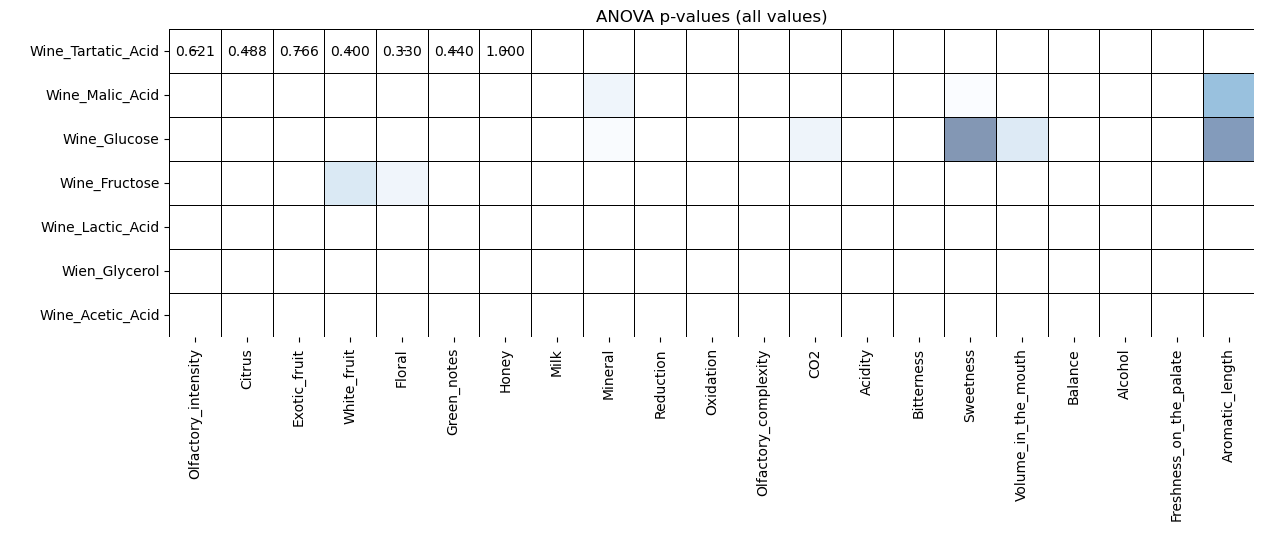

In [32]:
# ANOVA 
interaction_terms = ['Wine_Tartatic_Acid', 'Wine_Malic_Acid', 'Wine_Glucose',
       'Wine_Fructose', 'Wine_Lactic_Acid', 'Wien_Glycerol',
       'Wine_Acetic_Acid']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Wine_Tartatic_Acid + Wine_Malic_Acid + Wine_Glucose + Wine_Fructose + Wine_Lactic_Acid + Wien_Glycerol + Wine_Acetic_Acid"
    model = ols(formula, data=merged_df_all).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (all values)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

### PCA with more metadata 

In [33]:
merged_pca = merged_df_all.copy()

In [34]:
# scale the data to the range between 0 and 1 before using PCA
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(merged_pca[sensory_cols])

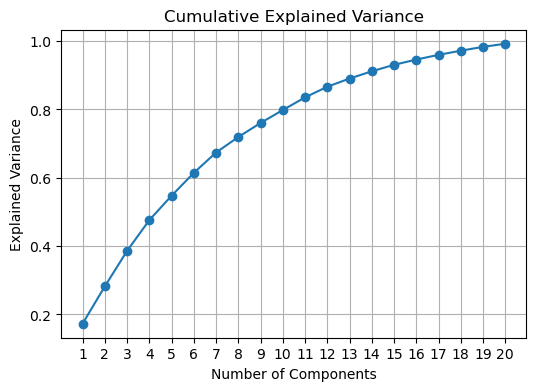

In [35]:
# Instantiate PCA with the max number of components to test --> 12? 
n_components = 20 
pca = PCA(n_components=n_components)

# Fit the PCA to your data
pca.fit(data_rescaled)

# Plot the explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(range(1, n_components + 1))
plt.grid(True)
plt.show()

Let's try a few components

In [36]:
# explaine 95% of variance
pca = PCA(n_components = 10)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

# Add PCA results to dataframe
merged_pca['PC1'] = reduced[:, 0]
merged_pca['PC2'] = reduced[:, 1]

In [37]:
merged_pca.columns

Index(['Sample', 'Judge', 'Olfactory_intensity', 'Citrus', 'Exotic_fruit',
       'White_fruit', 'Floral', 'Green_notes', 'Honey', 'Milk', 'Mineral',
       'Reduction', 'Oxidation', 'Olfactory_complexity', 'CO2', 'Acidity',
       'Bitterness', 'Sweetness', 'Volume_in_the_mouth', 'Balance', 'Alcohol',
       'Freshness_on_the_palate', 'Aromatic_length', 'PC1', 'PC2', 'Year',
       'Phenology_BudBreak', 'Phenology_Flowering', 'Hail_Damage', 'Herbicide',
       'Mildew', 'Grape_Yield_Estimate', 'Pruning_Weight', 'Must_Oechsle',
       'Wine_Tartatic_Acid', 'Wine_Malic_Acid', 'Wine_Glucose',
       'Wine_Fructose', 'Wine_Lactic_Acid', 'Wien_Glycerol',
       'Wine_Acetic_Acid', 'Altitude', 'Average_slope', 'Exposition',
       'Min_radiation', 'Max_radiation', 'Average_radiation', 'Soil_thickness',
       'Soil_type', 'Soil_depth', 'Hydromorphie', 'Hydromorphie_code',
       'Geology', 'Coordinates', 'Latitude', 'Longitude'],
      dtype='object')

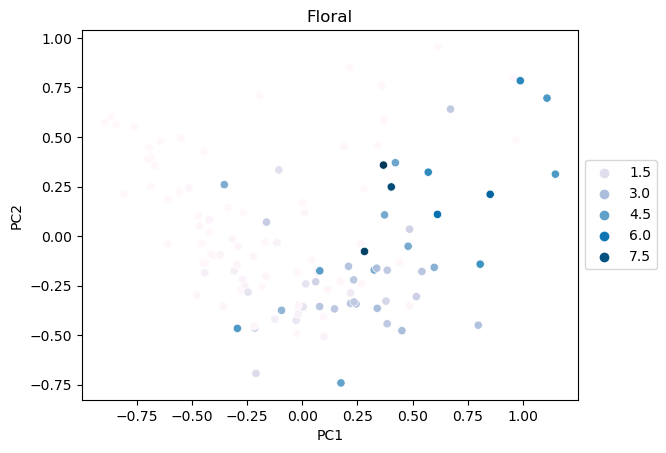

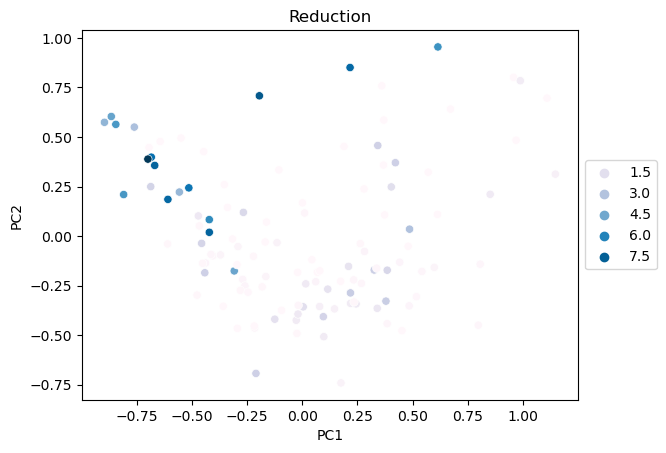

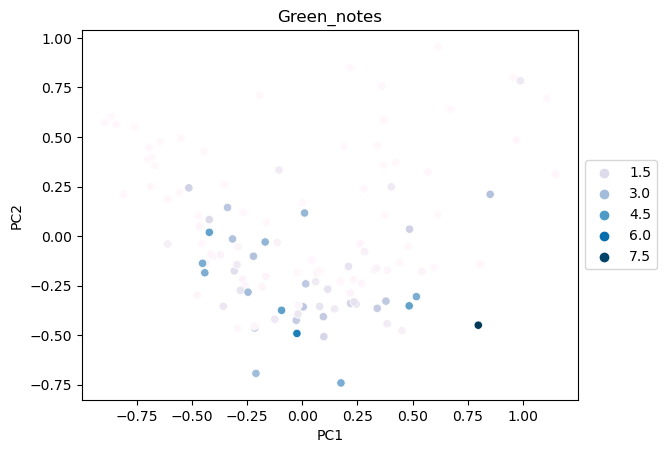

In [38]:
# PCA Floral
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Floral', palette='PuBu')
plt.title('Floral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PCA Reduction
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Reduction', palette='PuBu')
plt.title('Reduction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PCA Green_notes
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Green_notes', palette='PuBu')
plt.title('Green_notes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

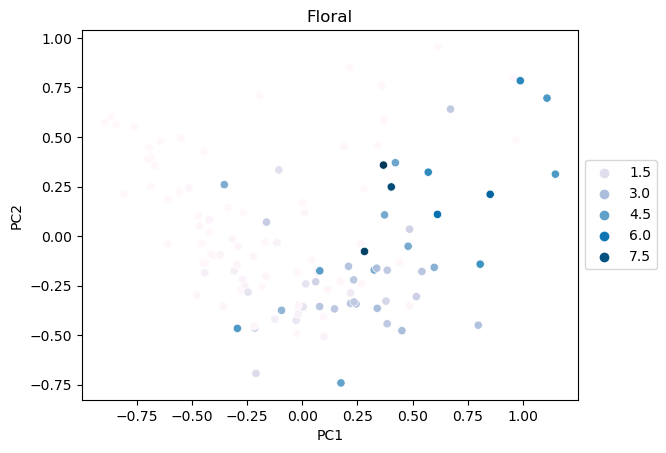

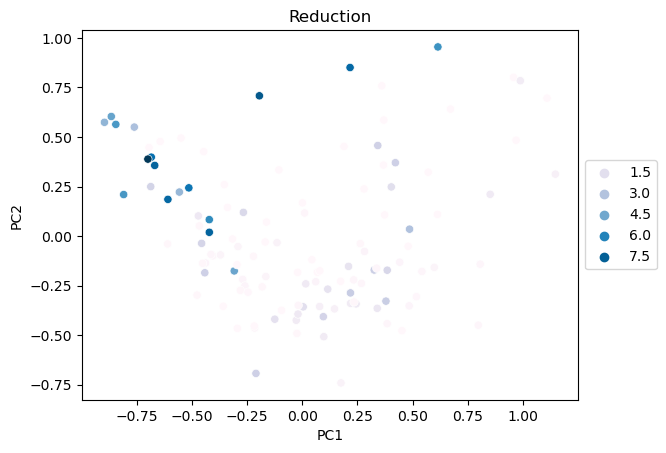

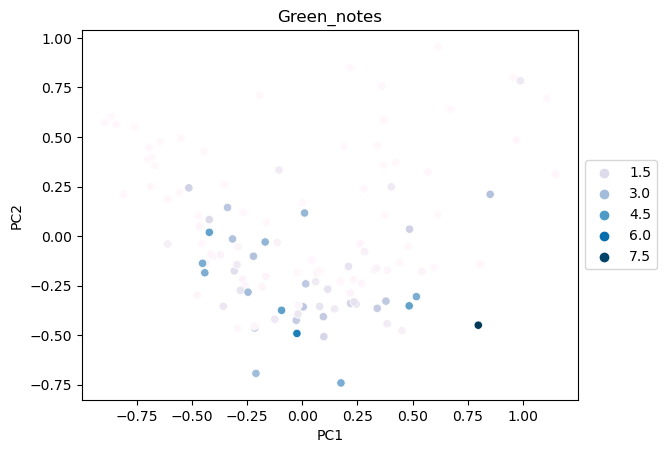

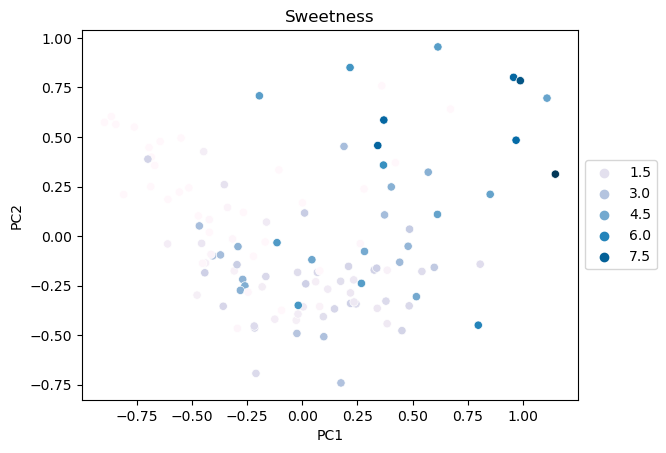

In [39]:
# PCA Floral
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Floral', palette='PuBu')
plt.title('Floral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PCA Reduction
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Reduction', palette='PuBu')
plt.title('Reduction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PCA Green_notes
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Green_notes', palette='PuBu')
plt.title('Green_notes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# PCA Sweetness
sns.scatterplot(data=merged_pca, x='PC1', y='PC2', hue='Sweetness', palette='PuBu')
plt.title('Sweetness')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Biplot with loadings

In [40]:
pca        = PCA()
scores     = pca.fit_transform(data_rescaled)
dfScores   = pd.DataFrame(scores,columns=['PC'+str(i) for i in range(1,merged_pca[sensory_cols].shape[1]+1)])
dfLoadings = pd.DataFrame(pca.components_,columns=merged_pca[sensory_cols].columns,index=dfScores.columns)

In [41]:
#function to produce biplot
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='#79b6c9')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  '#3e753b',
            'weight': 'bold',
            'size': 12,
            }
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = '#4c9141', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()

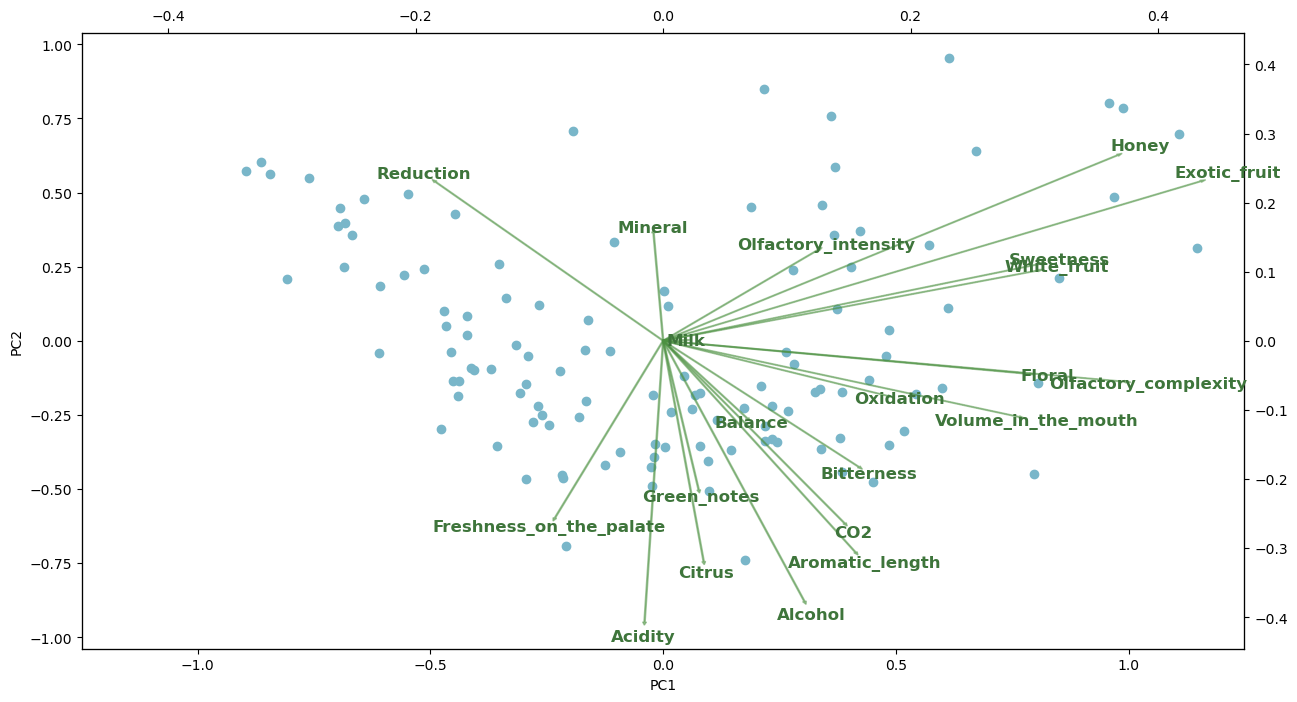

In [42]:
biplot(dfScores, dfLoadings)

## Box Plots 

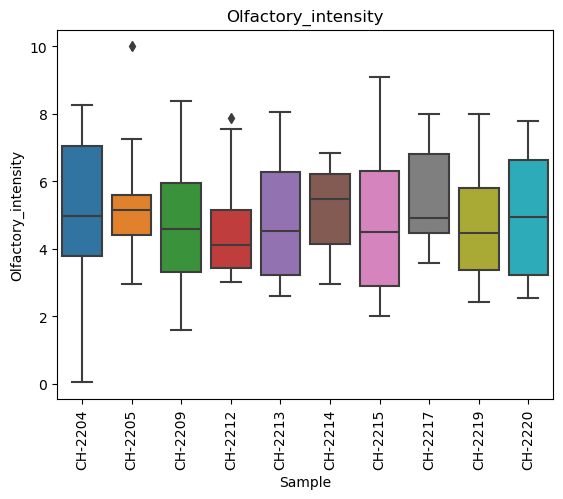

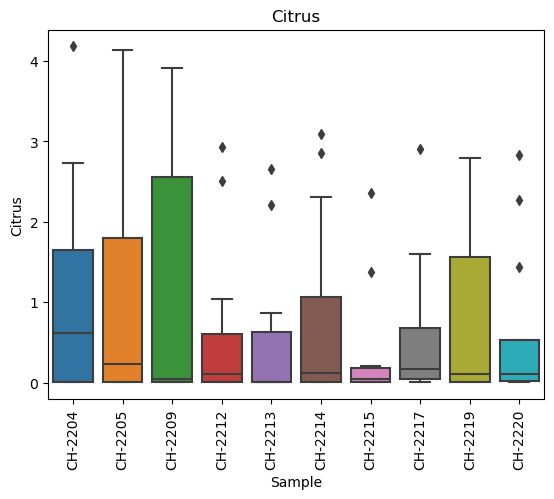

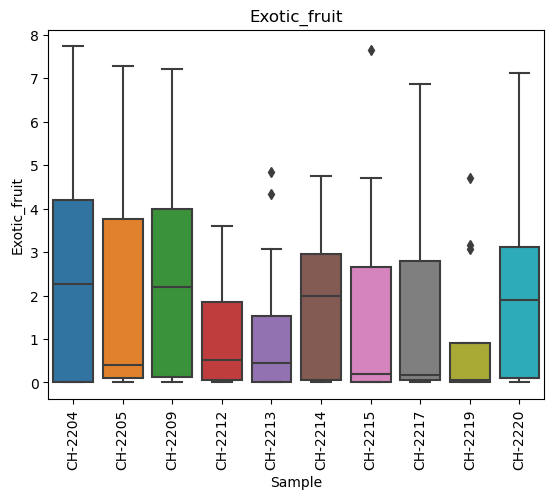

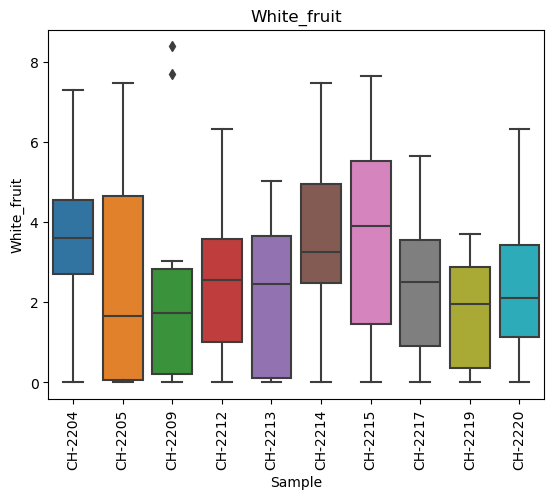

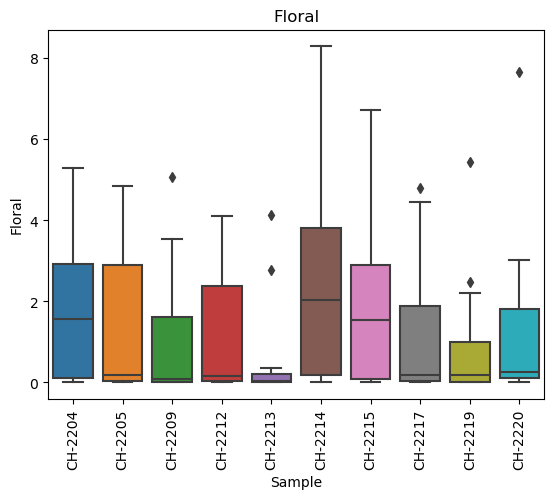

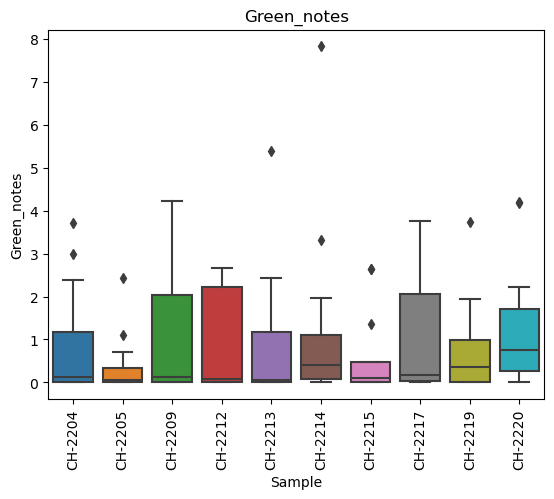

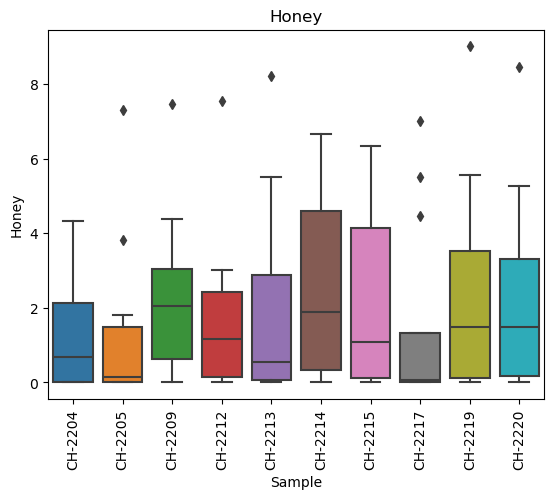

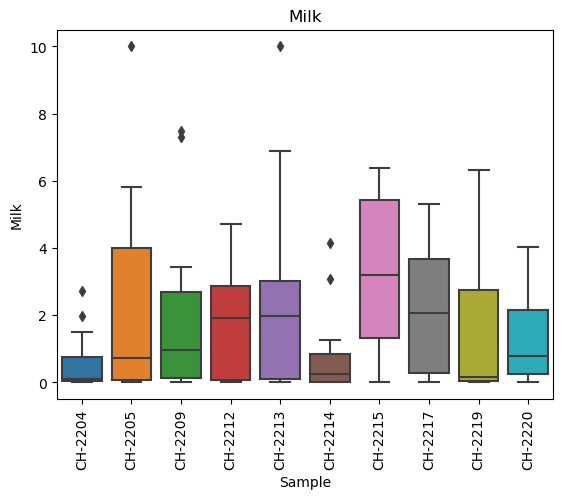

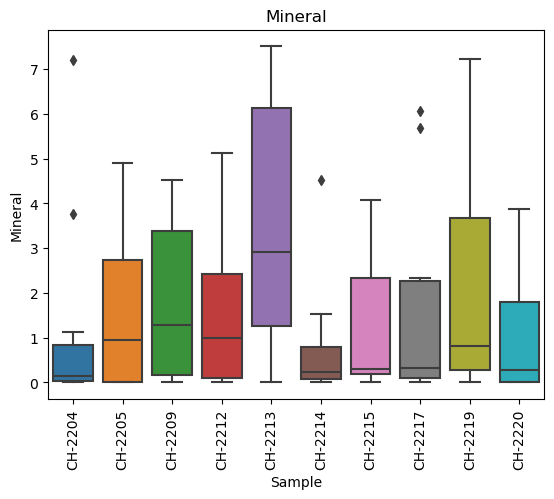

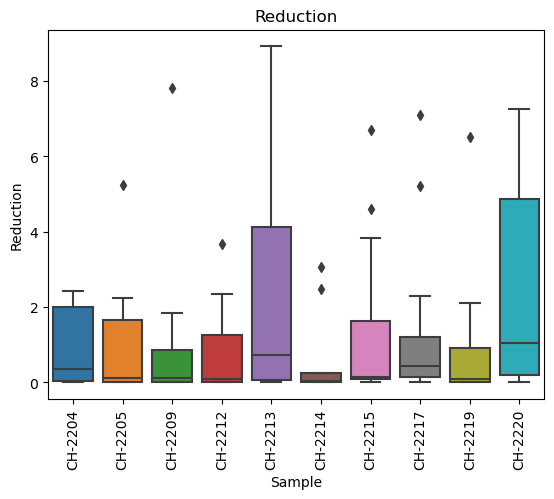

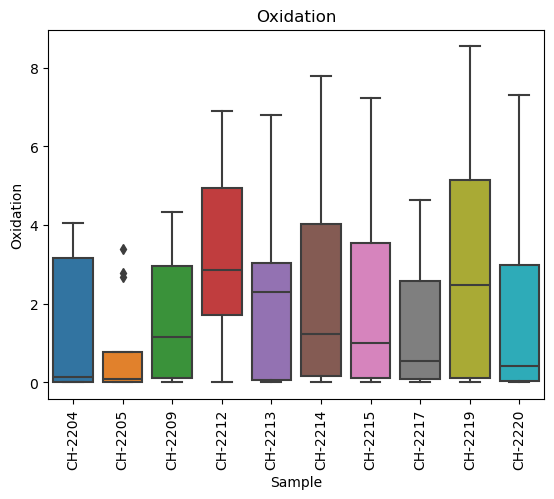

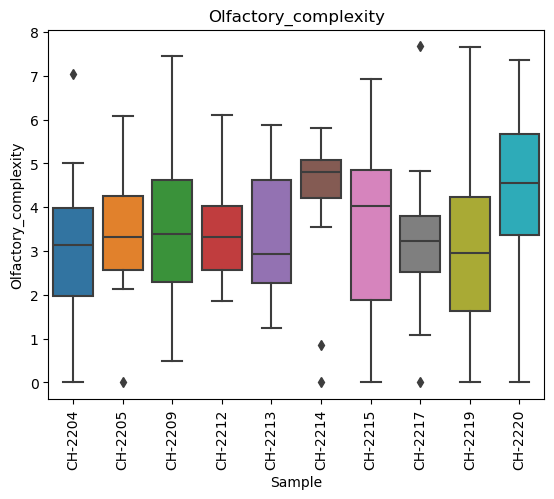

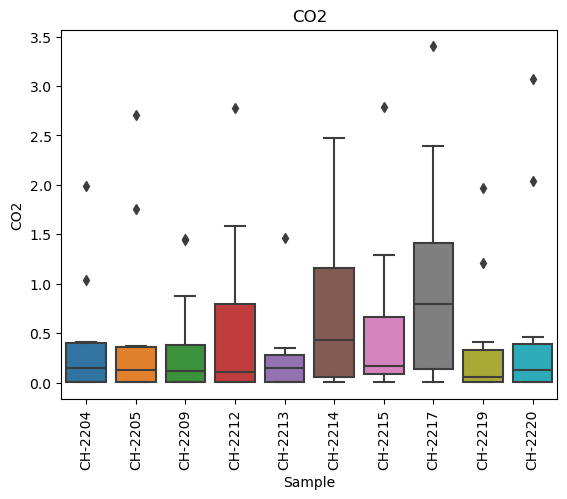

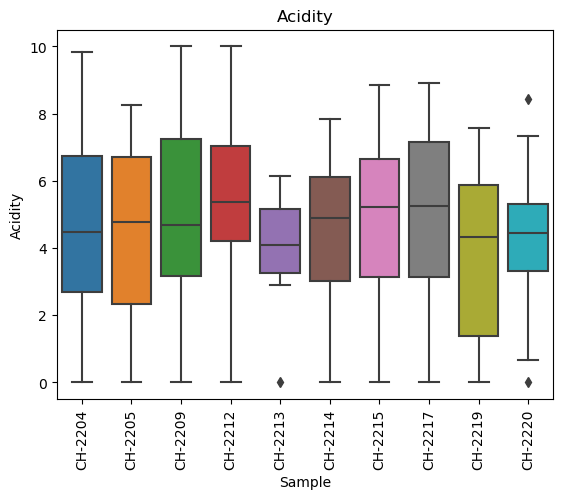

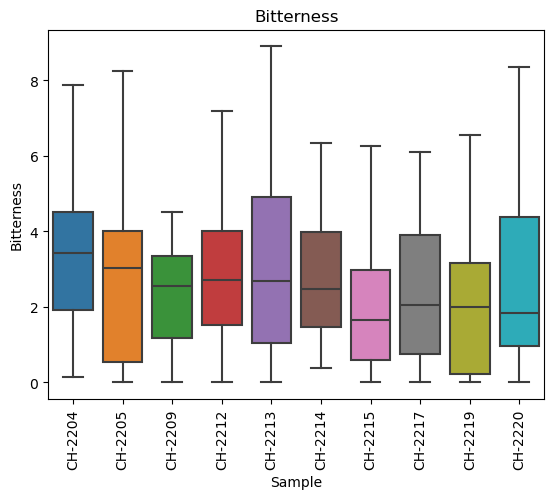

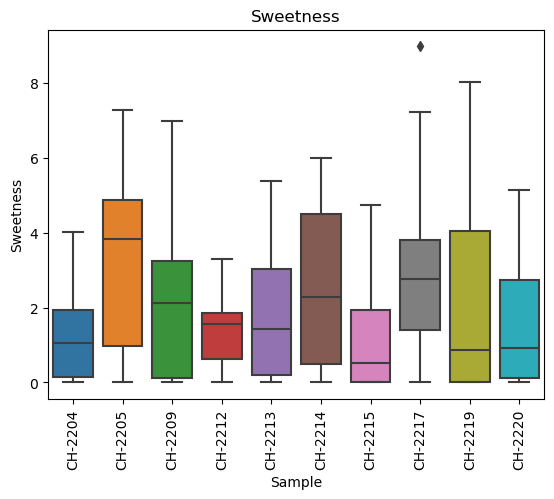

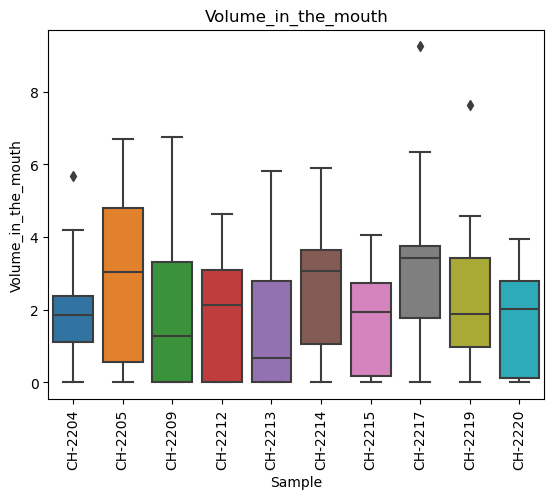

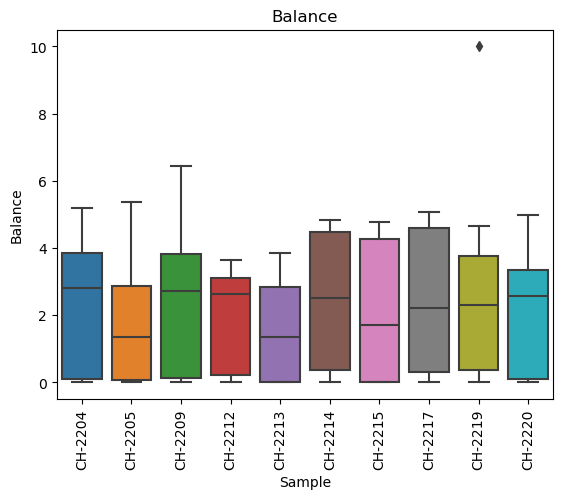

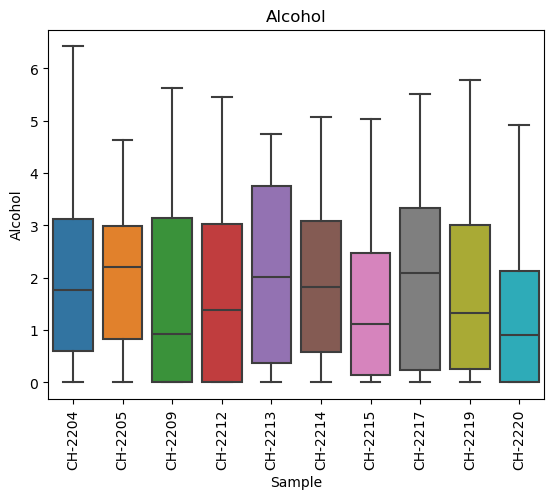

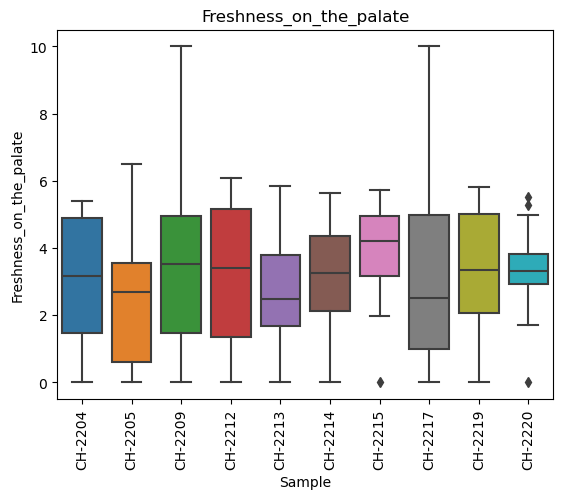

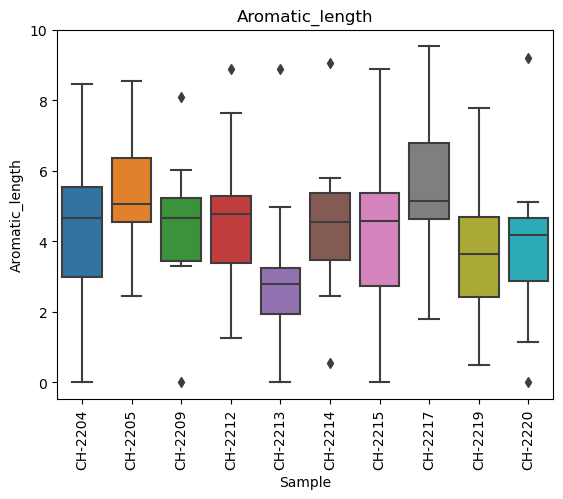

In [43]:
# individual box plots 
for col in numeric_cols:
    plt.figure()
    sns.boxplot(data=data, x='Sample', y=col)
    plt.title(f"{col}")
    plt.xlabel('Sample')
    plt.xticks(rotation=90)
    plt.ylabel(col)
    plt.show()

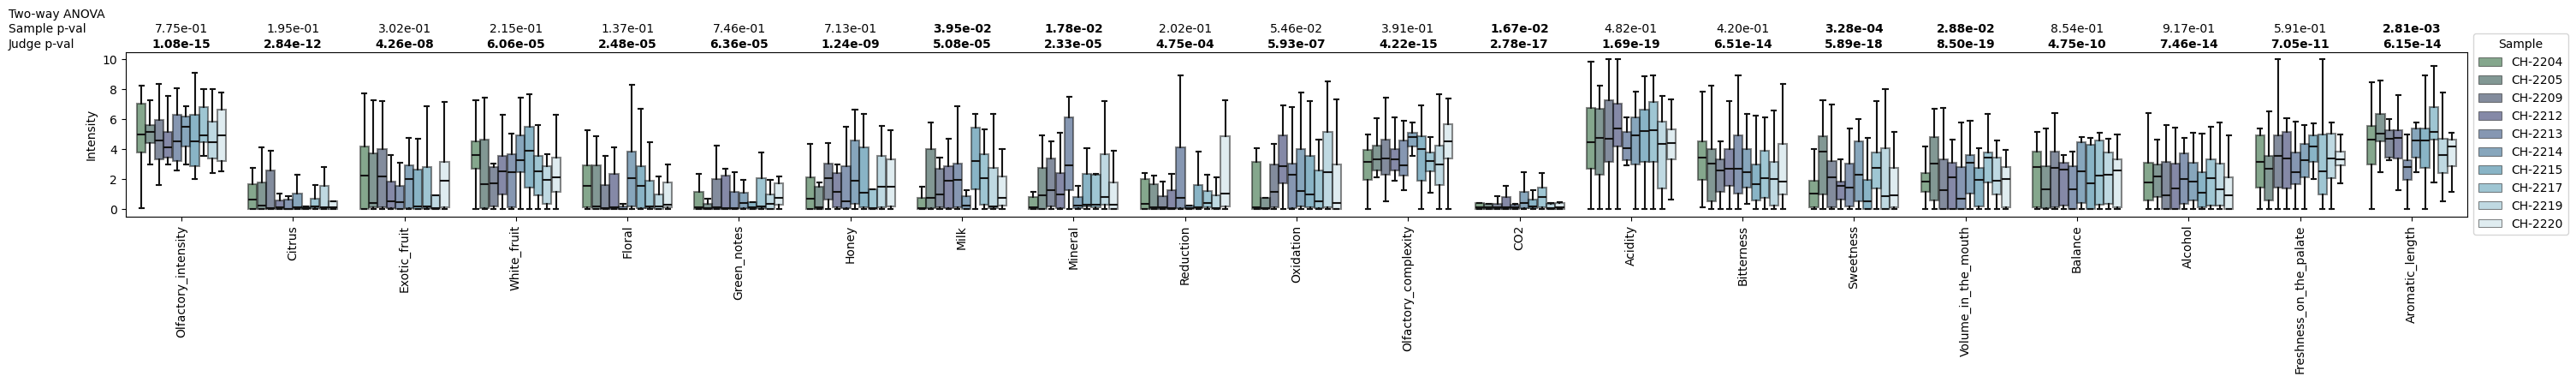

In [44]:
# one big box plot 
df_long = pd.melt(data, id_vars=['Sample'], value_vars=numeric_cols, var_name='Numeric')

# make box plots with seaborn 
plt.figure(figsize=(30, 5))
ax = sns.boxplot(data=df_long, x='Numeric', y='value', hue='Sample', 
             # palette as used below in the spider plots - change transparency to match
            palette='ocean',  boxprops=dict(alpha=0.5),
            showfliers=False) #, medianprops={'color': 'black'})


x_coordinates = range(len(df_long['Numeric'].unique()))


for x, (p_sample, p_judge) in zip(x_coordinates, zip(p_value_sample, p_value_judge)):
    if float(p_sample) < 0.05:
        ax.text(x, 12, p_sample, ha='center', va='center', fontsize=10, fontweight='bold')
    else:
        ax.text(x, 12, p_sample, ha='center', va='center', fontsize=10)
    if float(p_judge) <0.05:
        ax.text(x, 11, p_judge, ha='center', va='center', fontsize=10, fontweight='bold')
    else:
        ax.text(x, 11, p_judge, ha='center', va='center', fontsize=10)

ax.text(-1.55, 13, 'Two-way ANOVA', ha='left', va='center', fontsize=10)
ax.text(-1.55, 12, 'Sample p-val', ha='left', va='center', fontsize=10)
ax.text(-1.55, 11, 'Judge p-val', ha='left', va='center', fontsize=10)

# legend: adjust colors to match boxes 
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(0.5)

# Show the plot
plt.legend(handles, labels)

# labeling 
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Intensity')
#plt.title('Box Plots Grouped by "sample"')
plt.legend(handles, labels)
plt.legend(title='Sample', loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('/Users/lfloerl/Desktop/MICROTERROIR/Figures/Sensory_Barplots.png', bbox_inches='tight', dpi=1000) 

plt.tight_layout()
plt.show()

# Get median sensory values for each plot 

... save as a csv which can later be used as metadata? 

In [ ]:
# Select only numeric columns for median calculation
numeric_cols = data.select_dtypes(include='number').columns

# Group by 'Sample' and calculate the median for numeric columns only
median_data = data[numeric_cols].groupby(data['Sample']).median().reset_index()

In [51]:
median_data.head()

,Sample,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,...,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length,PC1,PC2
0,CH-2204,4.96,0.6150,2.265,3.600,1.5650,0.1250,0.690,0.095,0.140,...,4.475,3.425,1.050,1.865,2.800,1.770,3.165,4.655,-0.009264,-0.178853
1,CH-2205,5.16,0.2300,0.405,1.665,0.1850,0.0500,0.140,0.730,0.940,...,4.775,3.020,3.830,3.050,1.340,2.200,2.700,5.060,-0.006752,-0.135160
2,CH-2209,4.58,0.0405,2.185,1.740,0.0950,0.1200,2.055,0.965,1.295,...,4.680,2.565,2.135,1.280,2.735,0.925,3.535,4.670,-0.143721,-0.134839
3,CH-2212,4.10,0.1050,0.520,2.545,0.1500,0.0800,1.175,1.920,0.995,...,5.380,2.725,1.560,2.140,2.640,1.380,3.395,4.765,-0.023916,-0.177349
4,CH-2213,4.52,0.0105,0.445,2.455,0.0255,0.0505,0.545,1.980,2.915,...,4.085,2.690,1.430,0.680,1.340,2.010,2.470,2.790,-0.141736,0.125467


In [49]:
# rename the sample ID in order for a combined analysis with the GC-MS data 
median_data_renamed = median_data.copy()

median_data_renamed['Sample'] = median_data_renamed['Sample'].apply(lambda x: f"2022_Plot{x[5:]}")

# manually remove the 0 from Plot04 in the csv 
#median_data_renamed.to_csv('Sensory_data_median_renamed.csv')
median_data_renamed.head()

,Sample,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,...,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length,PC1,PC2
0,2022_Plot04,4.96,0.6150,2.265,3.600,1.5650,0.1250,0.690,0.095,0.140,...,4.475,3.425,1.050,1.865,2.800,1.770,3.165,4.655,-0.009264,-0.178853
1,2022_Plot05,5.16,0.2300,0.405,1.665,0.1850,0.0500,0.140,0.730,0.940,...,4.775,3.020,3.830,3.050,1.340,2.200,2.700,5.060,-0.006752,-0.135160
2,2022_Plot09,4.58,0.0405,2.185,1.740,0.0950,0.1200,2.055,0.965,1.295,...,4.680,2.565,2.135,1.280,2.735,0.925,3.535,4.670,-0.143721,-0.134839
3,2022_Plot12,4.10,0.1050,0.520,2.545,0.1500,0.0800,1.175,1.920,0.995,...,5.380,2.725,1.560,2.140,2.640,1.380,3.395,4.765,-0.023916,-0.177349
4,2022_Plot13,4.52,0.0105,0.445,2.455,0.0255,0.0505,0.545,1.980,2.915,...,4.085,2.690,1.430,0.680,1.340,2.010,2.470,2.790,-0.141736,0.125467


## Spider / Radar Plotting

--> Radar Chart https://python-graph-gallery.com/392-use-faceting-for-radar-chart/

Plot samples individually 

In [53]:
median_data_renamed.columns

Index(['Sample', 'Olfactory_intensity', 'Citrus', 'Exotic_fruit',
       'White_fruit', 'Floral', 'Green_notes', 'Honey', 'Milk', 'Mineral',
       'Reduction', 'Oxidation', 'Olfactory_complexity', 'CO2', 'Acidity',
       'Bitterness', 'Sweetness', 'Volume_in_the_mouth', 'Balance', 'Alcohol',
       'Freshness_on_the_palate', 'Aromatic_length', 'PC1', 'PC2'],
      dtype='object')

In [86]:
spider_df = median_data_renamed.copy()

spider_df.drop(columns=['PC1', 'PC2'], inplace=True)
spider_df['Sample'] = spider_df['Sample'].str.replace('2022_', '', regex=False)

spider_df = spider_df.rename(columns= {'Olfactory_intensity': 'Intensity',
                                       'Exotic_fruit' : 'Exotic fruit',
                                       'White_fruit' : 'White fruit',
                                       'Green_notes':'Green notes',
                                       'Olfactory_complexity': 'Complexity',
                                       'Volume_in_the_mouth' : 'Volumne',
                                       'Freshness_on_the_palate':'Freshness',
                                       'Aromatic_length':'Length'})

# Define the desired order of columns
column_order = ['Sample', 'Intensity', 'Citrus', 'Exotic fruit', 'White fruit',
       'Floral', 'Green notes', 'Honey', 'Milk', 'Mineral', 'Reduction',
       'Oxidation',  'CO2','Complexity', 'Acidity', 'Bitterness', 'Sweetness',
       'Volumne', 'Balance', 'Alcohol', 'Freshness', 'Length']
# Reorder the dataframe based on the new column order
spider_df = spider_df[column_order]

spider_df.head()


,Sample,Intensity,Citrus,Exotic fruit,White fruit,Floral,Green notes,Honey,Milk,Mineral,...,CO2,Complexity,Acidity,Bitterness,Sweetness,Volumne,Balance,Alcohol,Freshness,Length
0,Plot04,4.96,0.6150,2.265,3.600,1.5650,0.1250,0.690,0.095,0.140,...,0.145,3.130,4.475,3.425,1.050,1.865,2.800,1.770,3.165,4.655
1,Plot05,5.16,0.2300,0.405,1.665,0.1850,0.0500,0.140,0.730,0.940,...,0.130,3.315,4.775,3.020,3.830,3.050,1.340,2.200,2.700,5.060
2,Plot09,4.58,0.0405,2.185,1.740,0.0950,0.1200,2.055,0.965,1.295,...,0.115,3.395,4.680,2.565,2.135,1.280,2.735,0.925,3.535,4.670
3,Plot12,4.10,0.1050,0.520,2.545,0.1500,0.0800,1.175,1.920,0.995,...,0.105,3.315,5.380,2.725,1.560,2.140,2.640,1.380,3.395,4.765
4,Plot13,4.52,0.0105,0.445,2.455,0.0255,0.0505,0.545,1.980,2.915,...,0.145,2.940,4.085,2.690,1.430,0.680,1.340,2.010,2.470,2.790


/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_20911/3891730590.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("viridis", col_no)


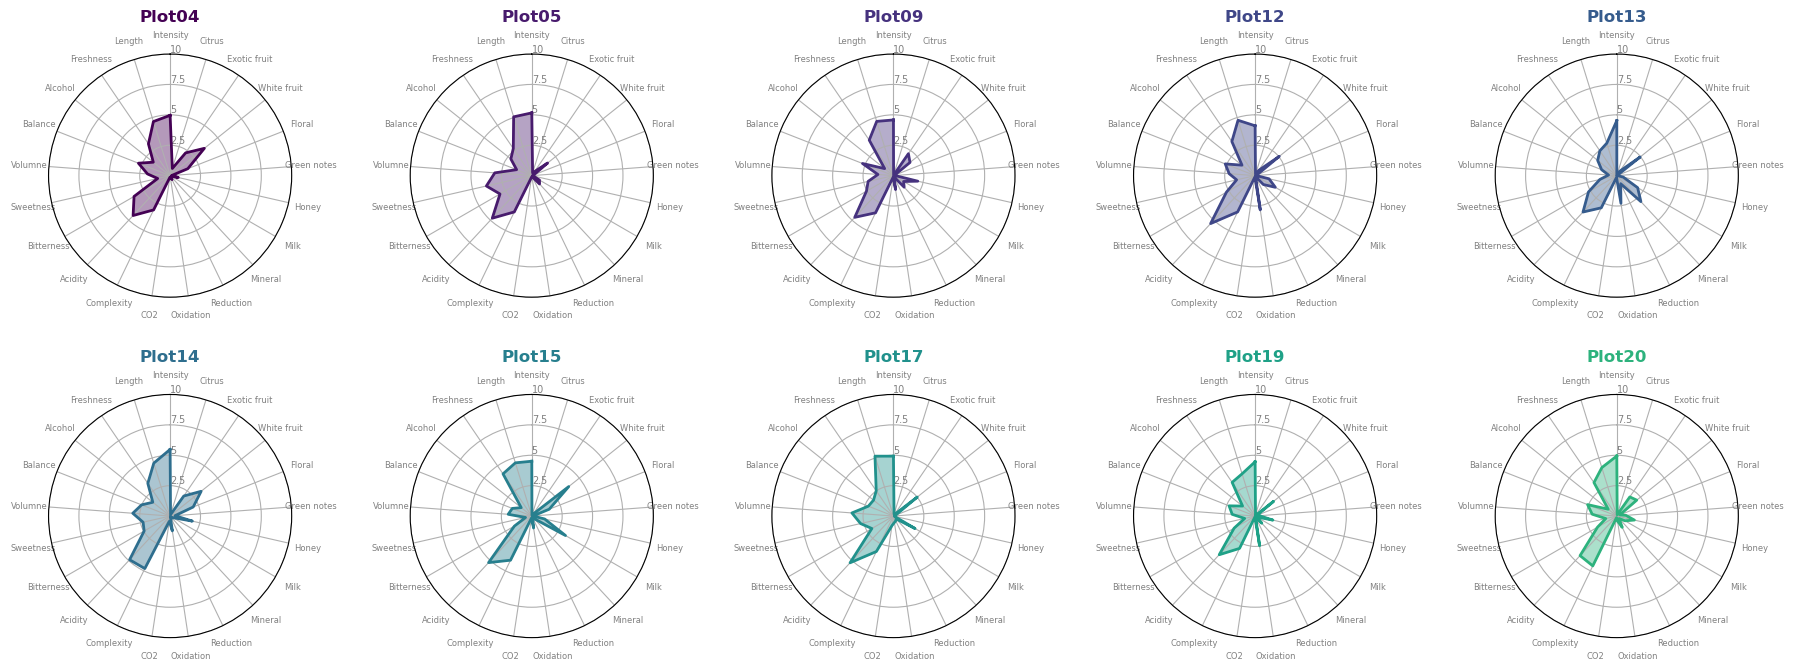

In [91]:
import matplotlib.pyplot as plt
from math import pi

def make_spider(row, title, color):
    # number of variable
    categories = list(spider_df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 5, row+1, polar=True)  # Adjusted layout to add more space

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=6)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([2.5, 5, 7.5, 10], ["2.5", "5", "7.5", "10"], color="grey", size=7)
    plt.ylim(0, 10)

    # Plot data
    values = spider_df.loc[row].drop('Sample').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title with larger and bold font
    plt.title(title, size=12, color=color, y=1.1, fontweight='bold')


# - PART 2: Apply the function to all individuals
# Initialize the figure
plt.figure(figsize=(22, 12), dpi=100)  # Adjusted figsize for more space

col_no = len(spider_df.index) + 5
# Create a color palette (tab20b?)
my_palette = plt.cm.get_cmap("viridis", col_no)

# Loop to plot
for row in range(0, len(spider_df.index)):
    make_spider(row=row, title=spider_df['Sample'][row], color=my_palette(row))

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('/Users/lfloerl/Desktop/MICROTERROIR/Figures/Sensory_Spiderplots.png', bbox_inches='tight', dpi=1000)
plt.show()

# Median data: Check metadata context

In [ ]:
# Plots Metadata
plots_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Lavaux_plots_md.csv', index_col=0)

In [ ]:
## modify the Sensory dataframe (median!) a bit to fit all the metadata 
data = median_data_renamed.copy()
# Extract the number after '2022_Plot' and convert to integer
data['Plot'] = data['Sample'].str.extract(r'2022_Plot(\d+)').astype(int)
# Set the new column as the index
data.set_index('Plot', inplace=True)
# Drop the original 'Sample' column 
data.drop(columns=['Sample', 'PC1', 'PC2'], inplace=True)

In [ ]:
# Microvinification data
mv_md = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Vineyard_MV_data.csv', index_col=0)
# only 2022 metadata
mv_md_2021= mv_md[mv_md['Year']==2021]

In [ ]:
# merge all!
merged_df = data.join([mv_md_2021, plots_md])

# these are the sensory cols 
sensory_cols = data.columns

### Plot Metadata

In [ ]:
# ANOVA 

interaction_terms = ['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Soil_thickness', 'Soil_type', 'Soil_depth', 'Geology']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Altitude + Average_slope + Exposition + Average_radiation + Soil_thickness + Soil_type + Soil_depth + Geology"
    model = ols(formula, data=merged_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan


# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (median)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,Reduction,...,Olfactory_complexity,CO2,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length
Altitude,0.241482,0.289724,0.805551,0.058496,0.014411,0.722604,0.649695,0.26108,0.371011,0.254787,...,0.08509,0.564325,0.066314,0.079436,0.675535,0.222972,0.826473,0.661992,0.911176,0.253733
Average_slope,0.52577,0.46327,0.639306,0.036309,0.01263,0.596036,0.647885,0.452758,0.720759,0.310314,...,0.301741,0.40875,0.225958,0.104849,0.738256,0.914351,0.68085,0.801325,0.834639,0.90773
Exposition,0.440886,0.513036,0.583836,0.034861,0.011922,0.718009,0.571209,0.500825,0.699899,0.355587,...,0.045675,0.362922,0.188802,0.126048,0.729998,0.886928,0.668193,0.838716,0.800027,0.900018
Average_radiation,0.566668,0.362569,0.73798,0.032494,0.013288,0.706108,0.877832,0.50239,0.747662,0.664544,...,0.125081,0.498922,0.303294,0.096068,0.584456,0.942413,0.772404,0.710585,0.9636,0.726676
Soil_thickness,0.305002,0.650502,0.702043,0.030944,0.011899,0.827125,0.893486,0.432574,0.744498,0.694281,...,0.020492,0.437941,0.335405,0.495013,0.635426,0.770656,0.881107,0.908031,0.705185,0.86228
Soil_type,0.515662,0.474993,0.638449,0.032039,0.011609,0.53667,0.692431,0.699049,0.689638,0.316691,...,0.078909,0.390601,0.118498,0.113546,0.729113,0.891838,0.712988,0.816533,0.750933,0.771077
Soil_depth,0.455575,0.765705,0.875725,0.045195,0.017496,0.868294,0.847266,0.513091,0.897351,0.455839,...,0.028512,0.389933,0.150847,0.234648,0.830291,0.83493,0.799487,0.949356,0.884186,0.963726
Geology,0.528208,0.668092,0.888932,0.057218,0.020429,0.398597,0.556353,0.475282,0.813553,0.465332,...,0.017812,0.586829,0.232376,0.082839,0.797689,0.785032,0.851886,0.9122,0.841073,0.863734


### Phenology

In [ ]:
# ANOVA 

interaction_terms = ['Phenology_BudBreak', 'Phenology_Flowering', 'Hail_Damage', 'Herbicide', 'Mildew', 'Must_Oechsle']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Phenology_Flowering + Phenology_BudBreak + Hail_Damage+ Herbicide + Mildew + Must_Oechsle"
    model = ols(formula, data=merged_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Print the resulting DataFrame
anova_results_df

,Olfactory_intensity,Citrus,Exotic_fruit,White_fruit,Floral,Green_notes,Honey,Milk,Mineral,Reduction,...,Olfactory_complexity,CO2,Acidity,Bitterness,Sweetness,Volume_in_the_mouth,Balance,Alcohol,Freshness_on_the_palate,Aromatic_length
Phenology_BudBreak,0.711154,0.4746,0.609791,0.28913,0.814092,0.578053,0.169527,0.701691,0.857032,0.632896,...,0.501896,0.333815,0.494565,0.516087,0.67178,0.486348,0.215123,0.310796,0.327435,0.208845
Phenology_Flowering,0.429181,0.707112,0.799782,0.138735,0.23316,0.541166,0.753215,0.316759,0.81663,0.290151,...,0.935319,0.191478,0.697427,0.701288,0.316976,0.410262,0.00361,0.996739,0.337132,0.212559
Hail_Damage,0.805519,0.681222,0.347539,0.96764,0.415196,0.596722,0.169424,0.19714,0.609633,0.623701,...,0.607131,0.120256,0.302505,0.869589,0.292201,0.29603,0.002673,0.332379,0.289511,0.111993
Herbicide,0.544966,0.793179,0.588849,0.329912,0.324384,0.702884,0.289515,0.384758,0.310072,0.363349,...,0.67124,0.281467,0.464329,0.921919,0.448601,0.611581,0.001738,0.601945,0.380584,0.065005
Mildew,0.809453,0.58217,0.53599,0.322377,0.82542,0.634084,0.922661,0.643386,0.57698,0.183734,...,0.99917,0.269583,0.818243,0.976197,0.316289,0.775517,0.001269,0.891161,0.600364,0.186876
Must_Oechsle,0.786244,0.962346,0.798659,0.368225,0.794734,0.642924,0.195422,0.23178,0.261067,0.229989,...,0.87937,0.494219,0.83993,0.647797,0.715747,0.664043,0.002248,0.390023,0.312502,0.121264


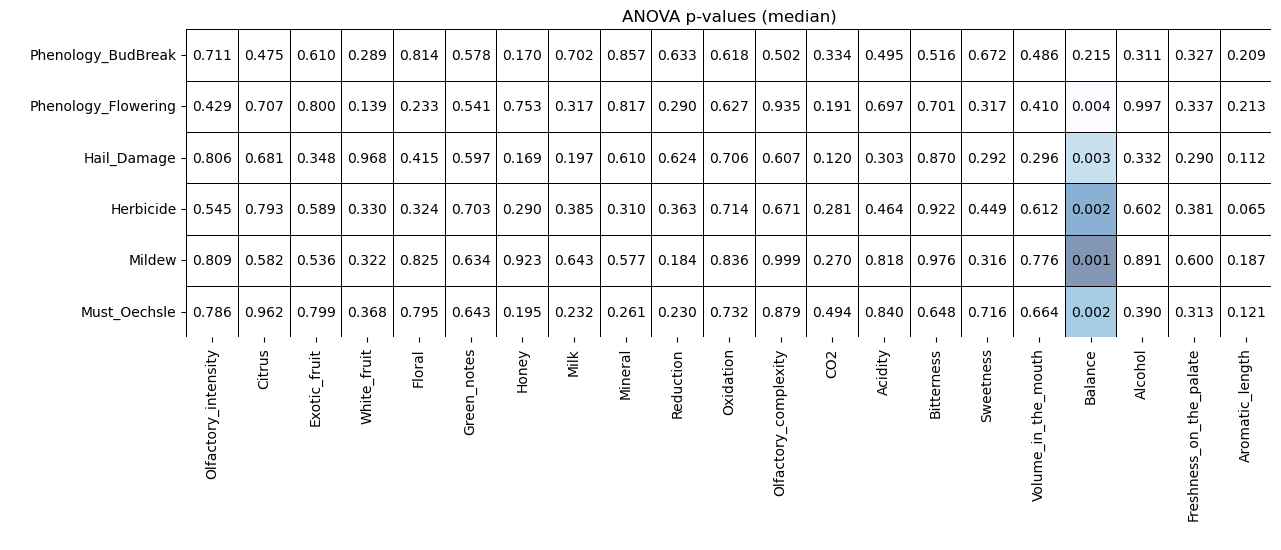

In [ ]:
# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (median)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()

### Wine Chemistry

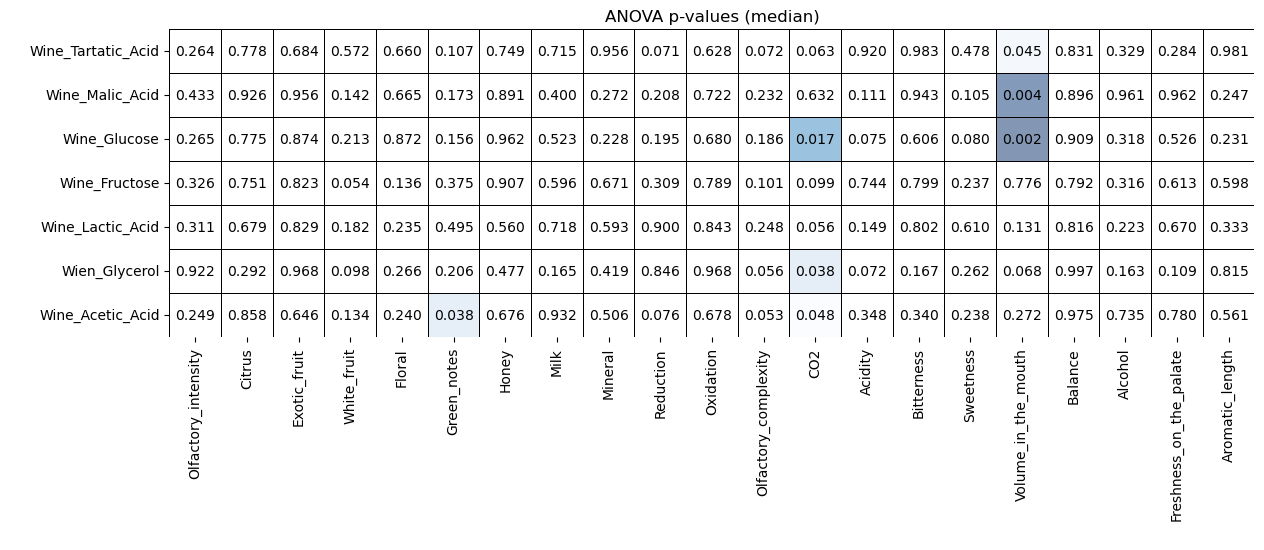

In [ ]:
# ANOVA 

interaction_terms = ['Wine_Tartatic_Acid', 'Wine_Malic_Acid', 'Wine_Glucose',
       'Wine_Fructose', 'Wine_Lactic_Acid', 'Wien_Glycerol',
       'Wine_Acetic_Acid']
anova_results_df = pd.DataFrame(index=interaction_terms, columns=sensory_cols)

# Loop over each sensory column and perform ANOVA
for col in sensory_cols: 
    # Perform nested ANOVA
    formula = f"{col} ~ Wine_Tartatic_Acid + Wine_Malic_Acid + Wine_Glucose + Wine_Fructose + Wine_Lactic_Acid + Wien_Glycerol + Wine_Acetic_Acid"
    model = ols(formula, data=merged_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract p-values and store them in the DataFrame
    for term in interaction_terms:
        if term in anova_table.index:
            anova_results_df.loc[term, col] = anova_table.loc[term, 'PR(>F)']
        else:
            anova_results_df.loc[term, col] = np.nan

# Convert DataFrame to float
anova_results_df = anova_results_df.astype(float)

# Create a mask for cells with p-values >= 0.05
mask = anova_results_df >= 0.05

# Custom colormap: significant values colored, non-significant values white
cmap = ListedColormap(['white', 'white', 'white'])

# Plot the heatmap
plt.figure(figsize=(14, 4))
sns.heatmap(anova_results_df, mask=mask, annot=True, cmap='Blues_r', cbar=False, alpha=0.5,
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Highlight significant p-values with a different colormap
sns.heatmap(anova_results_df, mask=~mask, annot=True, cmap=cmap, cbar=False, 
            linewidths=0.5, linecolor='black', fmt='.3f', 
            annot_kws={"color": "black"})

# Set title and labels
plt.title('ANOVA p-values (median)')
plt.xlabel(' ')
plt.ylabel(' ')

# Show the plot
plt.show()